In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python mediapipe tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import matplotlib.pyplot as plt

In [4]:
# Function to read and process hand landmark data from JSON files
def read_hand_landmarks_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data['hand_landmarks']

In [5]:
# Function to visualize the hand landmarks (x, y) as a scatter plot
def visualize_hand_landmarks(hand_landmarks, folder_name):
    x_coords = [landmark[0] for landmark in hand_landmarks]
    y_coords = [landmark[1] for landmark in hand_landmarks]
    plt.scatter(x_coords, y_coords, label=folder_name)

In [6]:
# Main function
def visualization():
    root_folder_path = 'data'  # Replace with the actual root folder path containing four sub-folders

    for folder_name in os.listdir(root_folder_path):
        folder_path = os.path.join(root_folder_path, folder_name)
        if os.path.isdir(folder_path):
            all_hand_landmarks = []

            for file_name in os.listdir(folder_path):
                if file_name.endswith('.json'):
                    json_file_path = os.path.join(folder_path, file_name)
                    hand_landmarks = read_hand_landmarks_from_json(json_file_path)
                    all_hand_landmarks.extend(hand_landmarks)

            # Visualize all hand landmarks in a single plot for each folder
            visualize_hand_landmarks(all_hand_landmarks, folder_name)

    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.title('Hand Landmarks')
    plt.legend()
    plt.show()

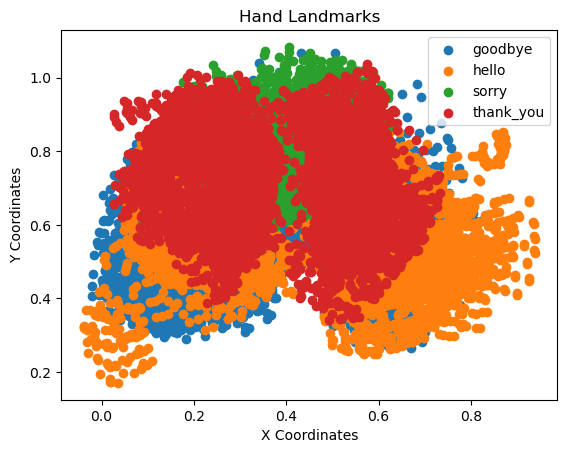

In [7]:
visualization()

In [92]:
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import load_model, save_model

In [93]:
# Function to read and process hand landmark data from JSON files
def read_hand_landmarks_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data['hand_landmarks']

In [94]:
# Function to extract features from hand landmarks (x, y) coordinates
def extract_features(hand_landmarks):
    x_coords = [landmark[0] for landmark in hand_landmarks]
    y_coords = [landmark[1] for landmark in hand_landmarks]
    return x_coords + y_coords

In [95]:
# Main function
def model():
    root_folder_path = 'data'  # Replace with the actual root folder path containing four sub-folders
    all_features = []
    all_labels = []

    for folder_name in os.listdir(root_folder_path):
        folder_path = os.path.join(root_folder_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.json'):
                    json_file_path = os.path.join(folder_path, file_name)
                    hand_landmarks = read_hand_landmarks_from_json(json_file_path)
                    features = extract_features(hand_landmarks)
                    all_features.append(features)
                    all_labels.append(folder_name)

    # Convert the features and labels to numpy arrays
    X = np.array(all_features)
    y = np.array(all_labels)

    # Perform label encoding to convert labels into numerical format
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build a custom neural network model
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(42,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    # Compile the model using Keras' Adam optimizer
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")

    # Save the trained model
    model.save('trained_model.h5')

    # Video processing
    video_path = 'C:/Users/Admin/OneDrive/Desktop/video.mp4'
    visualize_video_predictions(video_path, model, label_encoder)

In [98]:
def visualize_video_predictions(video_path, model, label_encoder):
    cap = cv2.VideoCapture(video_path)

    # Add this import statement
    mp_hands = mp.solutions.hands

    with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Convert the BGR frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the frame to get hand landmarks and predictions
            results = hands.process(frame_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Extract features from hand landmarks
                    features = extract_features(hand_landmarks.landmark)
                    # Reshape the features for prediction
                    features = np.array(features).reshape(1, -1)

                    # Make predictions
                    predicted_class = model.predict(features)
                    predicted_label = label_encoder.inverse_transform(predicted_class)[0]

                    # Draw the predicted sign on the frame
                    cv2.putText(frame, f"Predicted Sign: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                                (0, 255, 0), 2)

                    # Draw hand landmarks on the frame
                    mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Display the frame
            cv2.imshow('Sign Language Prediction', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [99]:
model()

Epoch 1/10
24/24 [==============================] - 1s 7ms/step - loss: 1.4206 - accuracy: 0.2513 - val_loss: 1.3864 - val_accuracy: 0.3646
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 1.3578 - accuracy: 0.4010 - val_loss: 1.3332 - val_accuracy: 0.4479
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 1.3257 - accuracy: 0.4154 - val_loss: 1.2965 - val_accuracy: 0.4531
Epoch 4/10
24/24 [==============================] - 0s 2ms/step - loss: 1.3025 - accuracy: 0.4388 - val_loss: 1.2745 - val_accuracy: 0.3958
Epoch 5/10
24/24 [==============================] - 0s 2ms/step - loss: 1.2824 - accuracy: 0.4284 - val_loss: 1.2525 - val_accuracy: 0.4375
Epoch 6/10
24/24 [==============================] - 0s 2ms/step - loss: 1.2655 - accuracy: 0.4622 - val_loss: 1.2346 - val_accuracy: 0.4948
Epoch 7/10
24/24 [==============================] - 0s 2ms/step - loss: 1.2493 - accuracy: 0.4701 - val_loss: 1.2146 - val_accuracy: 0.5000
Epoch 8/10
24/24 [==

TypeError: 'NormalizedLandmark' object is not subscriptable